In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Read the CSV file with specified column types
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date']  # Ensure 'Date' column is datetime
)

# Extract last 8 columns (swap rate maturities)
swap_rates = data.iloc[:, -8:]  # Only last 8 columns
currencies = data["Currency"]  # Currency column
dates = data["Date"]  # Date column

# Initialize empty lists for train and validation sets
train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

# Perform train-validation split at the currency level
for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency]  # Select rows for this currency
    currency_dates = dates[currencies == currency]  # Keep corresponding dates
    currency_labels = currencies[currencies == currency]  # Keep currency info

    # 90% train, 10% validation split
    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

# Combine back into DataFrames
train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

# Convert dates and currencies to NumPy for easy indexing
train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

# === SHUFFLE training data ===
train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

# === SHUFFLE validation data ===
val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

# Print tensor shapes for verification
print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

# Store tensors with their corresponding dates and currencies
train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [3]:
train_currencies_np

array(['GBP', 'AUD', 'AUD', ..., 'CAD', 'AUD', 'USD'], dtype=object)

In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=10):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Linear(8, latent_dim, bias=False)  # No bias in encoder per AE2 model
        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax()  
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]
        z = self.encoder(x)
        
        maturities = torch.arange(1, 31, dtype=torch.float32, device=x.device).repeat(batch_size, 1)
        z_repeated = z.unsqueeze(1).repeat(1, 30, 1)
        
        decoder_input = torch.cat([z_repeated, maturities.unsqueeze(-1)], dim=-1)
        hidden = self.activation(self.decoder_hidden(decoder_input))
        zero_coupon_rates = self.decoder_output(hidden).squeeze(-1)
        
        return zero_coupon_rates, z, maturities

# Convert zero-coupon rates to swap rates
def zero_coupon_to_swap_rates(zero_coupon_rates, maturities):
    discount_factors = torch.exp(-zero_coupon_rates * maturities)
    cumulative_sums = torch.tril(torch.ones(30, 30, device=zero_coupon_rates.device)) @ discount_factors.T
    cumulative_sums = cumulative_sums.T
    swap_rates = (1 - discount_factors) / cumulative_sums
    return swap_rates

# Set fixed parameters
initial_learning_rate = 0.01  # Initial LR
batch_size = 32
latent_dim = 2
hidden_dim = 10
epochs = 100

# Prepare data loaders
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = Autoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.9 ** (epoch // 50)  # Decays every 50 epochs
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = "best_autoencoder_model.pth"

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        zero_coupon_rates, _, maturities = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch in val_loader:
            zero_coupon_rates, _, maturities = model(X_batch)
            swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
            val_loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
            total_val_loss += val_loss.item()
    
    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5
    val_losses.append(avg_val_loss)

    # Update learning rate scheduler
    scheduler.step()

    # Save model if validation loss is best so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'train_loss': avg_train_loss,
            'latent_dim': latent_dim,
            'hidden_dim': hidden_dim,
        }, best_model_path)
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch 0, Train RMSE: 0.051433, Val RMSE: 0.016514, LR: 0.010000


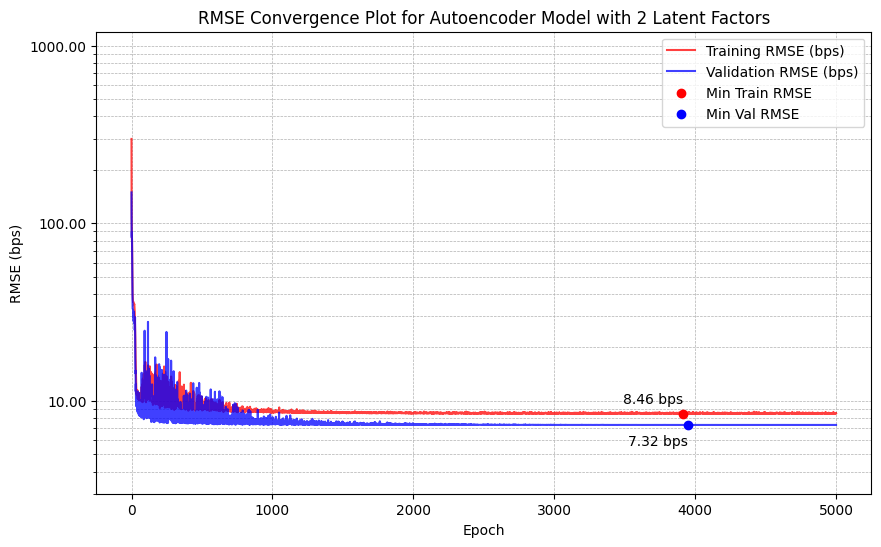

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Convert RMSE values to basis points (bps)
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 0.9, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 1.9, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log')  # Log-scale y-axis
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot for Autoencoder Model with 2 Latent Factors')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
# Define shared y-axis ticks for log scale
shared_ticks = [10, 100, 1000]  # or whatever range makes sense for you

plt.yscale('log')
plt.ylim(3, 1200)  # Or your chosen limits
plt.yticks(shared_ticks)
plt.gca().set_yticklabels([f"{tick:.2f}" for tick in shared_ticks])  # Format if needed
plt.show()

In [7]:
import pandas as pd
import torch
import torch.nn as nn

# Load full data (already wide format)
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test data from 2023 and 2024
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Define function to compute RMSE
def compute_rmse(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
        return mse_loss.sqrt().item()

# Compute RMSE for each currency
currency_rmse = []

for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse = compute_rmse(model, currency_train_tensor) * 10_000
    val_rmse = compute_rmse(model, currency_val_tensor) * 10_000
    test_rmse = compute_rmse(model, currency_test_tensor) * 10_000

    currency_rmse.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse
    })

# Create DataFrame and add average row
rmse_df = pd.DataFrame(currency_rmse)
rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean()
]

# Print RMSE table
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)
     AUD          9.321732               8.431000        13.419299
     CAD          8.592277               8.248420        27.618336
     DKK          7.873462               4.181573        15.266008
     EUR          7.865044               5.376179        16.534679
     GBP          9.017612               9.337810              NaN
     JPY          8.636029               8.038338         3.264638
     NOK          7.902584               8.243258        14.475469
     SEK          7.796919               5.361024        16.123543
     USD          9.523138               9.023395        28.314153
 Average          8.503199               7.360111        16.877016


In [8]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

# Load and filter test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Updated function: return per-curve RMSEs
def compute_rmse_and_std(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        
        # ✅ Standard RMSE (same as before)
        mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
        rmse = mse_loss.sqrt().item()

        # ✅ Per-curve RMSEs for std
        per_curve_mse = torch.mean((swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]] - data_tensor) ** 2, dim=1)
        per_curve_rmse = torch.sqrt(per_curve_mse)
        std = per_curve_rmse.std().item()

        return rmse * 10_000, std * 10_000  # Convert to bps

# Compute RMSE + STD for each currency
currency_rmse = []

for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse, train_std = compute_rmse_and_std(model, currency_train_tensor)
    val_rmse, val_std = compute_rmse_and_std(model, currency_val_tensor)
    test_rmse, test_std = compute_rmse_and_std(model, currency_test_tensor)

    currency_rmse.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Train STD (bps)": train_std,
        "Validation RMSE (bps)": val_rmse,
        "Validation STD (bps)": val_std,
        "Test RMSE (bps)": test_rmse,
        "Test STD (bps)": test_std
    })

# Convert to DataFrame and add average row
rmse_df = pd.DataFrame(currency_rmse)
rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Train STD (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Validation STD (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean(),
    rmse_df["Test STD (bps)"].mean()
]

# Print nicely
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Train STD (bps)  Validation RMSE (bps)  Validation STD (bps)  Test RMSE (bps)  Test STD (bps)
     AUD          9.321732         4.978576               8.431000              3.762380        13.419299        2.648837
     CAD          8.592277         4.723690               8.248420              3.601700        27.618336        4.648903
     DKK          7.873462         4.550928               4.181573              2.117499        15.266008        4.730759
     EUR          7.865044         4.529334               5.376179              1.848413        16.534679        5.298419
     GBP          9.017612         4.476566               9.337810              4.786379              NaN             NaN
     JPY          8.636029         4.137156               8.038338              3.906782         3.264638        1.188632
     NOK          7.902584         3.712809               8.243258              3.744169        14.475469        3.783442
     SEK          7.7969

/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_933/4206458122.py:24: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = per_curve_rmse.std().item()


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# Prepare 8 observed maturity positions
maturity_labels = [1, 2, 3, 5, 10, 15, 20, 30]
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]

# Function to compute RMSE per maturity for a given tensor
def compute_rmse_per_maturity(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        swap_rates_selected = swap_rates[:, selected_indices]

        mse_per_maturity = torch.mean((swap_rates_selected - data_tensor) ** 2, dim=0)
        rmse_per_maturity = torch.sqrt(mse_per_maturity) * 10_000  # Convert to bps
        return rmse_per_maturity.cpu().numpy()

# Compute per-maturity RMSEs
rmse_train = compute_rmse_per_maturity(model, train_tensor)
rmse_val   = compute_rmse_per_maturity(model, val_tensor)

# Prepare test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
rmse_test = compute_rmse_per_maturity(model, test_tensor)

# Create DataFrame
rmse_by_maturity = pd.DataFrame({
    "Maturity (Years)": maturity_labels,
    "Train RMSE (bps)": rmse_train,
    "Validation RMSE (bps)": rmse_val,
    "Test RMSE (bps)": rmse_test
})

rmse_by_maturity

,Maturity (Years),Train RMSE (bps),Validation RMSE (bps),Test RMSE (bps)
0,1,13.874616,11.901686,33.360683
1,2,3.218035,2.876420,4.687866
2,3,7.467778,6.495962,17.347563
3,5,10.900929,9.747090,23.410246
4,10,7.731559,7.294048,9.564425
5,15,4.492498,4.175278,8.425782
6,20,4.648548,4.318561,12.555239
7,30,10.068523,8.717898,11.995809


In [10]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

# Load and filter test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Updated function: return per-curve RMSEs
def compute_rmse_and_std(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        errors = torch.sqrt(torch.mean((swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]] - data_tensor) ** 2, dim=1))
        rmse = errors.mean().item()
        std = errors.std().item()
        return rmse * 10_000, std * 10_000  # Convert to bps

# Compute RMSE + STD for each currency
currency_rmse = []

for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse, train_std = compute_rmse_and_std(model, currency_train_tensor)
    val_rmse, val_std = compute_rmse_and_std(model, currency_val_tensor)
    test_rmse, test_std = compute_rmse_and_std(model, currency_test_tensor)

    currency_rmse.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Train STD (bps)": train_std,
        "Validation RMSE (bps)": val_rmse,
        "Validation STD (bps)": val_std,
        "Test RMSE (bps)": test_rmse,
        "Test STD (bps)": test_std
    })

# Convert to DataFrame and add average row
rmse_df = pd.DataFrame(currency_rmse)
rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Train STD (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Validation STD (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean(),
    rmse_df["Test STD (bps)"].mean()
]

# Print nicely
print(rmse_df.to_string(index=False))
import pandas as pd
import torch
import torch.nn as nn

# Define function to compute RMSE
def compute_rmse(model, data_tensor):
    model.eval()
    with torch.no_grad():
        zero_coupon_rates, _, maturities = model(data_tensor)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
        return mse_loss.sqrt().item()

# Compute RMSE for each currency
currency_rmse = []
for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )

    train_rmse = compute_rmse(model, currency_train_tensor) * 10_000  # Convert to bps
    val_rmse = compute_rmse(model, currency_val_tensor) * 10_000  # Convert to bps
    
    currency_rmse.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse
    })

# Convert to DataFrame
rmse_df = pd.DataFrame(currency_rmse)

# Add average row
average_train_rmse = rmse_df["Train RMSE (bps)"].mean()
average_val_rmse = rmse_df["Validation RMSE (bps)"].mean()
rmse_df.loc[len(rmse_df)] = ["Average", average_train_rmse, average_val_rmse]

# Print DataFrame
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Train STD (bps)  Validation RMSE (bps)  Validation STD (bps)  Test RMSE (bps)  Test STD (bps)
     AUD          7.892118         4.978576               7.603352              3.762380        13.174310        2.648837
     CAD          7.188828         4.723690               7.478570              3.601700        27.252592        4.648903
     DKK          6.436656         4.550928               3.644446              2.117499        14.569469        4.730759
     EUR          6.441318         4.529334               5.069538              1.848413        15.726655        5.298419
     GBP          7.839226         4.476566               8.126964              4.786379              NaN             NaN
     JPY          7.588622         4.137156               7.092662              3.906782         3.057112        1.188632
     NOK          6.983198         3.712809               7.403288              3.744169        14.008826        3.783442
     SEK          6.1696

/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_933/15952782.py:18: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = errors.std().item()


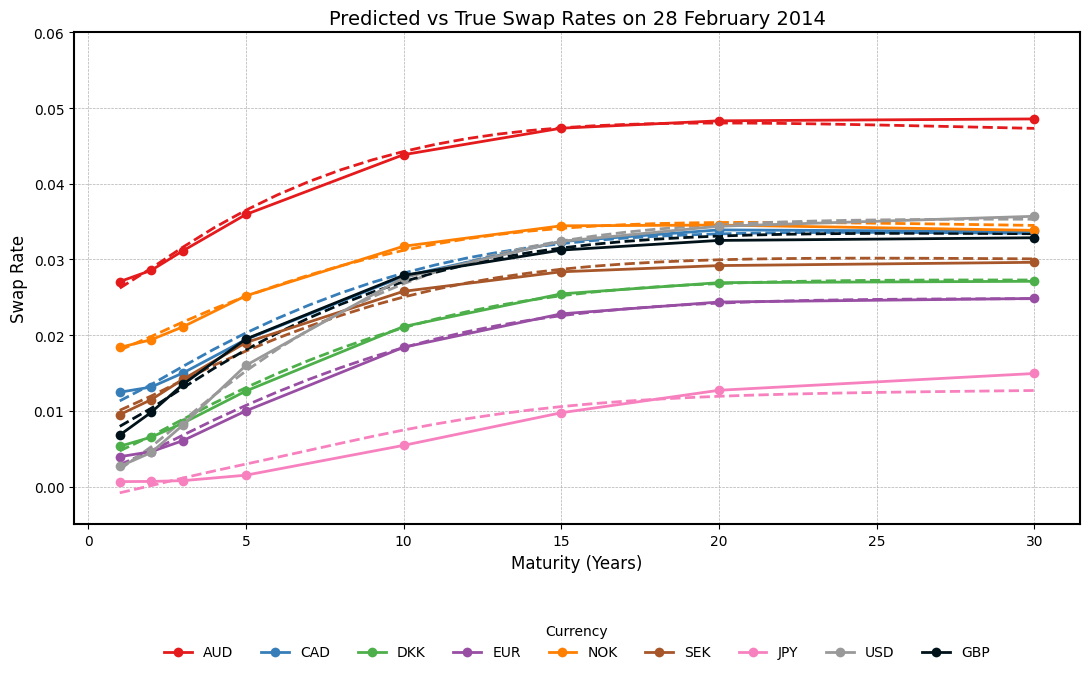

In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
with torch.no_grad():
    zero_coupon_rates_pred, _, maturities = model(selected_data)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities).cpu().numpy()

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# --- Build long-format DataFrame ---
plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Set desired currency order and colors ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted (dashed lines)
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True (solid lines with filled markers)
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Customize true markers (bigger + filled)
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

# Axis styling
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Legend
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

# Grid and border styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

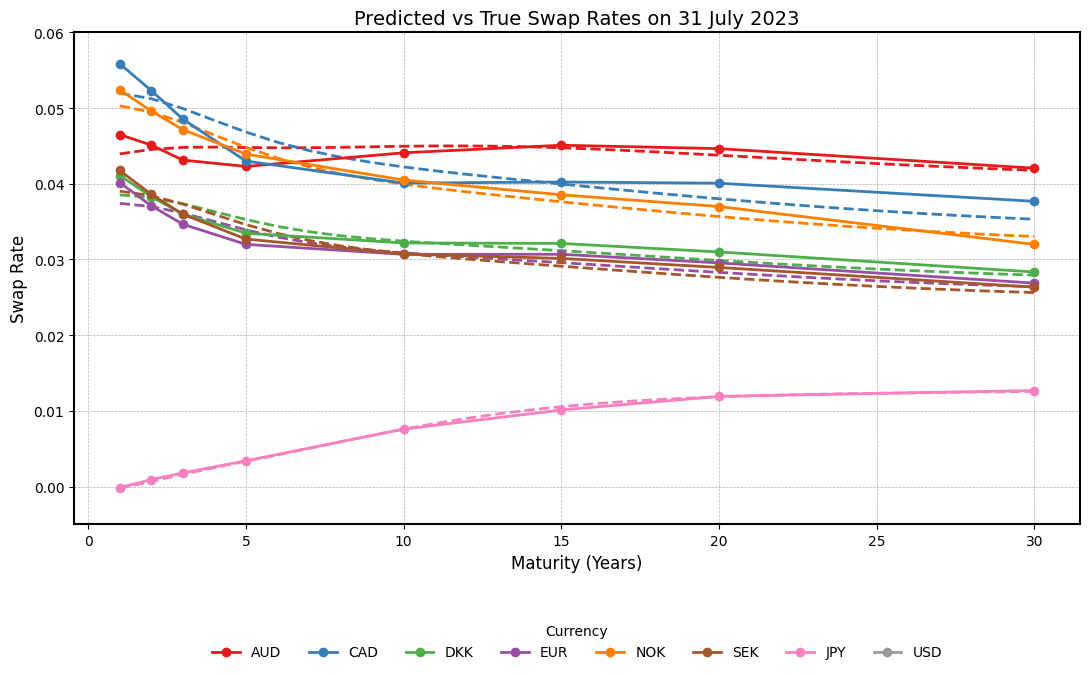

In [12]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

# Extract input swap rates and metadata
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

# --- Model predictions ---
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(filtered_data_tensor)
    predicted_swaps = zero_coupon_to_swap_rates(zero_coupon_pred, maturities).cpu().numpy()

# --- Build long-form DataFrame ---
plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Define custom order and palette ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted curves
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

# Plot true swap rates (with larger, filled markers)
lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# --- Remove white border & increase marker size ---
for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     # Increase size
        line.set_markerfacecolor(line.get_color()) # Fill with line color
        line.set_markeredgewidth(0)                # Remove border


# Axis formatting
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

# Labels and title
plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Custom legend with desired order
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

# Grid and styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

# Combine train and validation datasets into one dataset
data_tensor = torch.cat((train_tensor, val_tensor), dim=0)
data_currencies_np = np.concatenate((train_currencies_np, val_currencies_np))

# Define function for leave-one-currency-out cross-validation
def leave_one_currency_out_cv(model, data_tensor, data_currencies_np):
    unique_currencies = np.unique(data_currencies_np)
    results = []
    
    for left_out_currency in unique_currencies:
        print(f"Leaving out: {left_out_currency}")
        
        # Split data into training and test sets
        train_mask = data_currencies_np != left_out_currency
        test_mask = data_currencies_np == left_out_currency
        
        train_data = data_tensor[train_mask]
        test_data = data_tensor[test_mask]
        
        # Train model on training data
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9 ** (epoch // 50))
        criterion = torch.nn.MSELoss()
        
        for epoch in range(5000):  # Small number of epochs for demonstration
            optimizer.zero_grad()
            zero_coupon_rates_pred, _, maturities = model(train_data)
            swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)
            loss = criterion(swap_rates_pred[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # Evaluate model on test and train data
        model.eval()
        with torch.no_grad():
            # RMSE for unseen currency (test set)
            zero_coupon_rates_pred_test, _, maturities = model(test_data)
            swap_rates_pred_test = zero_coupon_to_swap_rates(zero_coupon_rates_pred_test, maturities)
            rmse_unseen = torch.sqrt(criterion(swap_rates_pred_test[:, [0, 1, 2, 4, 9, 14, 19, 29]], test_data)).item() * 10_000  # Convert to basis points
            
            # RMSE for seen currencies (train set)
            zero_coupon_rates_pred_train, _, maturities = model(train_data)
            swap_rates_pred_train = zero_coupon_to_swap_rates(zero_coupon_rates_pred_train, maturities)
            rmse_seen = torch.sqrt(criterion(swap_rates_pred_train[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)).item() * 10_000  # Convert to basis points
        
        results.append({"Currency Left Out": left_out_currency, "RMSE Unseen (bps)": rmse_unseen, "RMSE Seen (bps)": rmse_seen})
    
    return results

# Run leave-one-currency-out cross-validation
cv_results = leave_one_currency_out_cv(model, data_tensor, data_currencies_np)

# Print results
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.to_string(index=False))


Leaving out: AUD
Leaving out: CAD
Leaving out: DKK
Leaving out: EUR
Leaving out: GBP
Leaving out: JPY
Leaving out: NOK
Leaving out: SEK
Leaving out: USD
Currency Left Out  RMSE Unseen (bps)  RMSE Seen (bps)
              AUD           9.665104         8.302476
              CAD           8.745065         8.422083
              DKK           7.760916         8.539706
              EUR           7.800572         8.521609
              GBP           9.386790         8.369202
              JPY          10.076906         8.346912
              NOK           8.164648         8.525351
              SEK           7.820074         8.598630
              USD           9.591008         8.336980


In [14]:
cv_results_df.loc["Average"] = ["Average", cv_results_df["RMSE Unseen (bps)"].mean(), cv_results_df["RMSE Seen (bps)"].mean()]

# Print results
print(cv_results_df.to_string(index=False))

Currency Left Out  RMSE Unseen (bps)  RMSE Seen (bps)
              AUD           9.665104         8.302476
              CAD           8.745065         8.422083
              DKK           7.760916         8.539706
              EUR           7.800572         8.521609
              GBP           9.386790         8.369202
              JPY          10.076906         8.346912
              NOK           8.164648         8.525351
              SEK           7.820074         8.598630
              USD           9.591008         8.336980
          Average           8.779009         8.440328


Worst RMSE date: 2022-04-29T00:00:00.000000000, RMSE: 0.0019


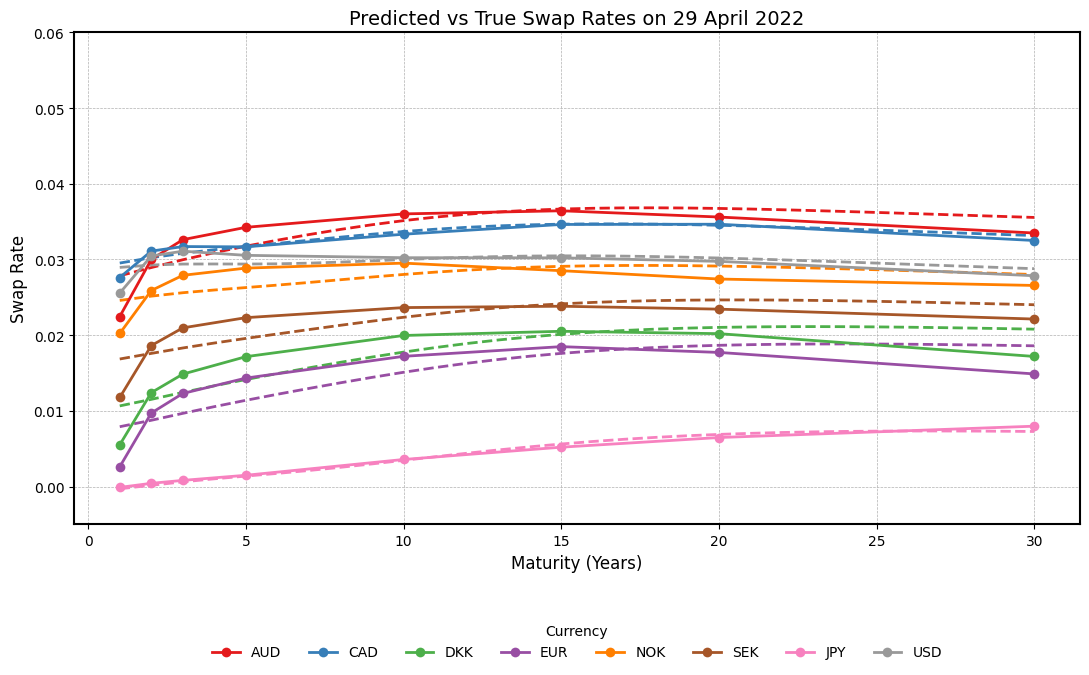

In [19]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Define maturities
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Step 1: Find the date with the highest average per-curve RMSE in train + val
def get_rmse_by_date(tensor, dates_np):
    unique_dates = np.unique(dates_np)
    date_rmse = {}
    model.eval()
    with torch.no_grad():
        for date in unique_dates:
            mask = dates_np == date
            if mask.sum() == 0:
                continue
            data = tensor[mask]
            zero_coupon, _, maturities = model(data)
            swap_rates = zero_coupon_to_swap_rates(zero_coupon, maturities)
            swap_sel = swap_rates[:, selected_indices]
            rmse_per_curve = torch.sqrt(torch.mean((swap_sel - data) ** 2, dim=1))
            date_rmse[date] = rmse_per_curve.mean().item()
    return date_rmse

# Compute RMSEs for training and validation
train_rmse_by_date = get_rmse_by_date(train_tensor, train_dates_np)
val_rmse_by_date = get_rmse_by_date(val_tensor, val_dates_np)

# Combine and find date with highest RMSE
all_rmse_by_date = {**train_rmse_by_date, **val_rmse_by_date}
worst_date = max(all_rmse_by_date, key=all_rmse_by_date.get)
print(f"Worst RMSE date: {worst_date}, RMSE: {all_rmse_by_date[worst_date]:.4f}")

# Step 2: Filter data for that date
train_mask = train_dates_np == worst_date
val_mask = val_dates_np == worst_date
selected_data = torch.cat((train_tensor[train_mask], val_tensor[val_mask]), dim=0)
selected_currencies = np.concatenate((train_currencies_np[train_mask], val_currencies_np[val_mask]))

# Step 3: Predict
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(selected_data)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities).cpu().numpy()

# Step 4: Build long-format DataFrame
plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]
    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})
df_plot = pd.DataFrame(plot_data)

# Step 5: Plot
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD']
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999"
}

plt.figure(figsize=(11, 7))

# Predicted
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Format markers
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

# Axis
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title(f"Predicted vs True Swap Rates on {pd.to_datetime(worst_date).strftime('%d %B %Y')}", fontsize=14)
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

Worst test RMSE date: 2023-12-29 00:00:00, RMSE: 0.0020


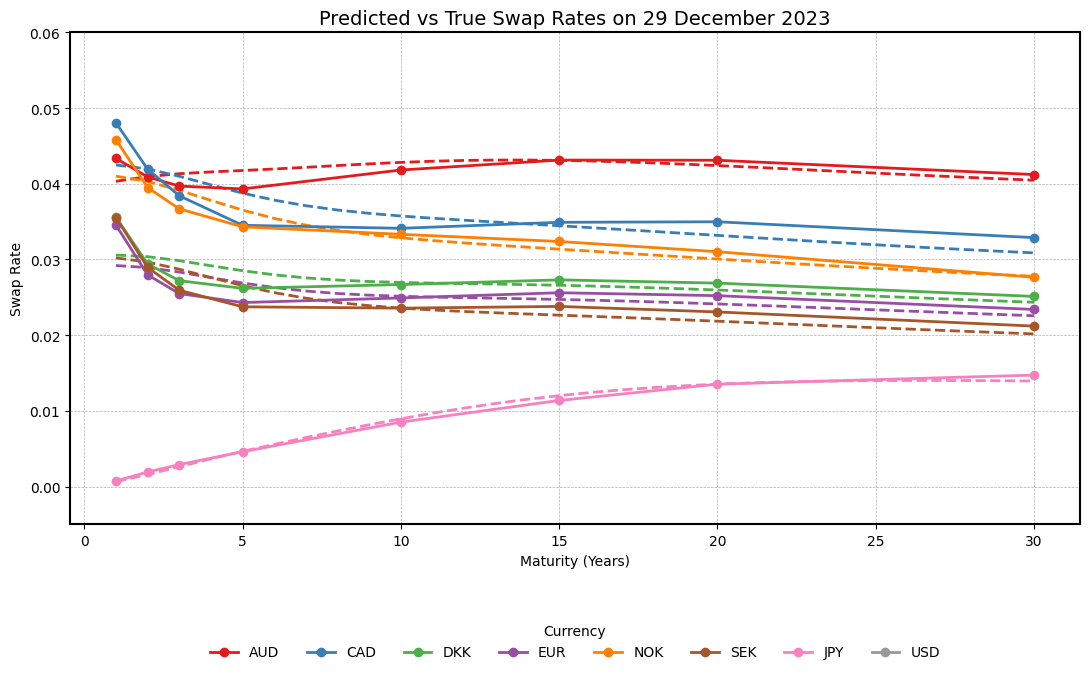

In [18]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Define maturities
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# Load test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Step 1: Compute RMSE per date
def get_test_rmse_by_date(model, test_df):
    unique_dates = test_df['Date'].unique()
    date_rmse = {}
    model.eval()
    with torch.no_grad():
        for date in unique_dates:
            day_df = test_df[test_df['Date'] == date]
            if day_df.empty:
                continue
            data_tensor = torch.tensor(day_df.iloc[:, 2:].values, dtype=torch.float32)
            zero_coupon, _, maturities = model(data_tensor)
            swap_rates = zero_coupon_to_swap_rates(zero_coupon, maturities)
            swap_sel = swap_rates[:, selected_indices]
            rmse_per_curve = torch.sqrt(torch.mean((swap_sel - data_tensor) ** 2, dim=1))
            date_rmse[date] = rmse_per_curve.mean().item()
    return date_rmse

# Run and find worst date
test_rmse_by_date = get_test_rmse_by_date(model, test_df)
worst_test_date = max(test_rmse_by_date, key=test_rmse_by_date.get)
print(f"Worst test RMSE date: {worst_test_date}, RMSE: {test_rmse_by_date[worst_test_date]:.4f}")

# Step 2: Prepare data for plotting
worst_day_df = test_df[test_df['Date'] == worst_test_date]
true_tensor = torch.tensor(worst_day_df.iloc[:, 2:].values, dtype=torch.float32)
currencies = worst_day_df['Currency'].values

# Predict
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(true_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities).cpu().numpy()

# Step 3: Build plot DataFrame
plot_data = []
for i, currency in enumerate(currencies):
    true_row = true_tensor[i].cpu().numpy()
    pred_row = swap_rates_pred[i]
    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1], "Currency": currency, "Type": "Predicted"})
df_plot = pd.DataFrame(plot_data)

# Step 4: Plot
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD']
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999"
}

plt.figure(figsize=(11, 7))

# Predicted
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Format true markers
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

plt.title(f"Predicted vs True Swap Rates on {pd.to_datetime(worst_test_date).strftime('%d %B %Y')}", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

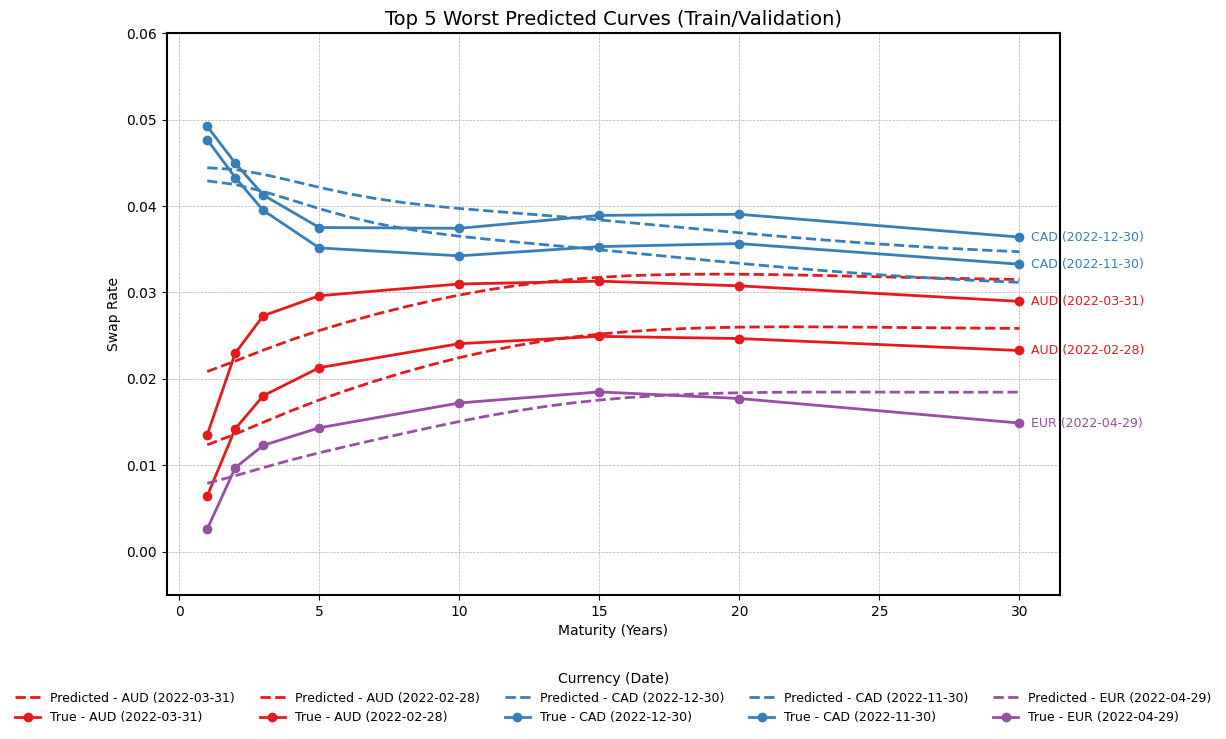

In [55]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define distinct marker styles
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# Combine train + validation
train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

# --- Model Prediction ---
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(train_val_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

# --- Top 10 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    # Annotate last point (30Y) of true curve
    plt.text(
        x=selected_maturities[-1] + 0.4,
        y=true_curve[-1],
        s=label,
        fontsize=9,
        color=color,
        verticalalignment='center'
    )


# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,  # You can set this to 9 if each label is short, but 2–3 is often clearer
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Add this line to shift plot up for legend space
plt.show()

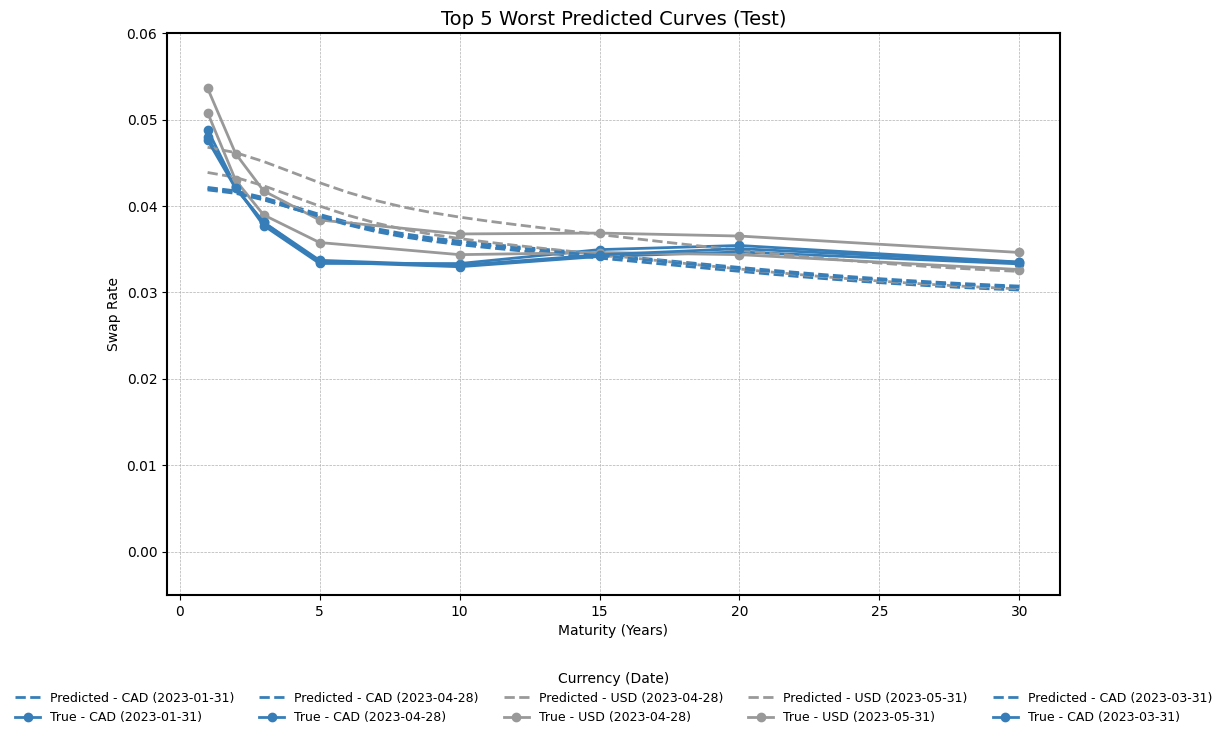

In [40]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Prepare test data ---
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# --- Model Prediction ---
model.eval()
with torch.no_grad():
    zero_coupon_pred, _, maturities = model(test_tensor)
    swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
    selected_pred = swap_rates_pred[:, selected_indices]
    rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

# --- Top 5 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

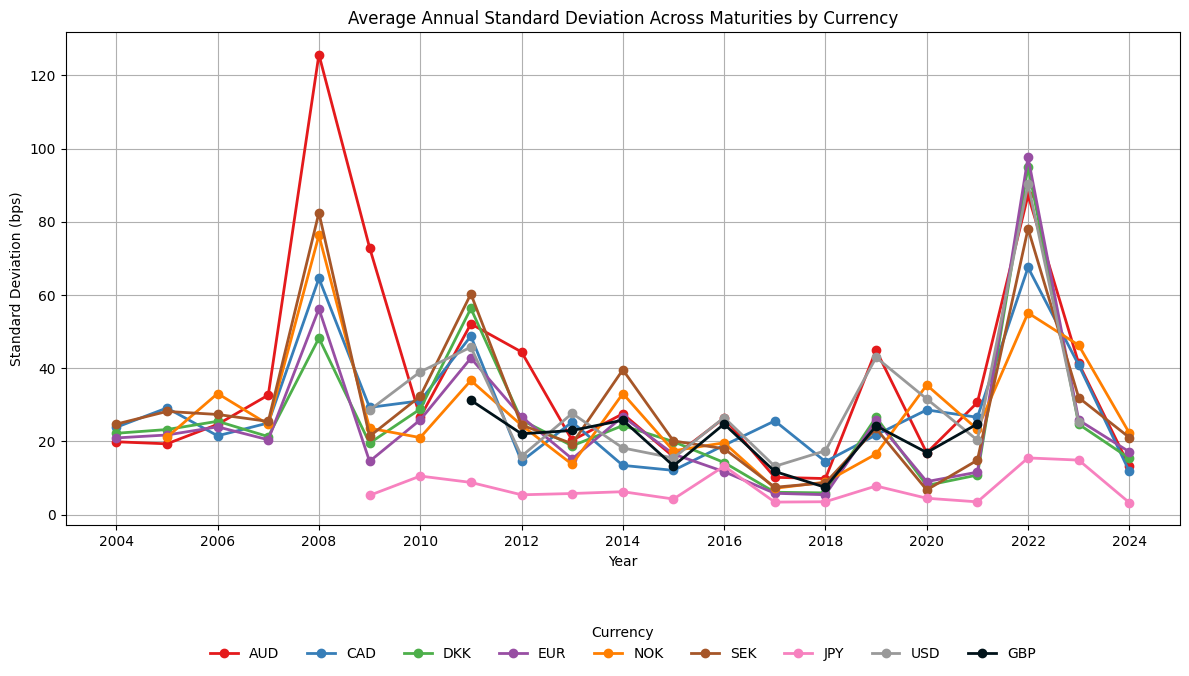

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
data = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
data['Year'] = data['Date'].dt.year

# Prepare long format
maturity_columns = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_long = data.melt(id_vars=['Date', 'Currency', 'Year'], value_vars=maturity_columns,
                      var_name='Maturity', value_name='Rate')

# Compute std per maturity per year per currency
grouped_std = data_long.groupby(['Year', 'Currency', 'Maturity'])['Rate'].std().reset_index(name='Maturity_STD')

# Average across maturities
avg_std_by_currency_year = grouped_std.groupby(['Year', 'Currency'])['Maturity_STD'].mean().reset_index()
avg_std_by_currency_year['Maturity_STD_bps'] = avg_std_by_currency_year['Maturity_STD'] * 10_000

# Plot using loop to keep line formatting consistent
plt.figure(figsize=(12, 7))
for currency in legend_order:
    currency_data = avg_std_by_currency_year[avg_std_by_currency_year['Currency'] == currency]
    if not currency_data.empty:
        plt.plot(currency_data['Year'], currency_data['Maturity_STD_bps'],
                 label=currency, color=custom_palette[currency], marker='o', linewidth=2)

# Assuming your x-axis is years ranging from 2000 to 2024
years = sorted(avg_std_by_currency_year['Year'].unique())  # or use avg_std_by_currency_year['Year'].unique()
min_year = min(years)
max_year = max(years)

# Set x-ticks every 2 years
plt.xticks(ticks=np.arange(min_year, max_year + 1, 2))

plt.title("Average Annual Standard Deviation Across Maturities by Currency")
plt.ylabel("Standard Deviation (bps)")
plt.xlabel("Year")
plt.grid(True)
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)
plt.tight_layout()
plt.show()


In [60]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])

# --- Create Year column ---
data_full["Year"] = data_full["Date"].dt.year

# --- Define splits ---
train_df = data_full[data_full["Year"].between(2010, 2016)].copy()
val_df = data_full[data_full["Year"].between(2017, 2022)].copy()
test_df = data_full[data_full["Year"].isin([2023, 2024])].copy()

# --- Define a function to count inversions ---
def count_inversions_by_currency(df):
    results = {}
    for currency, group in df.groupby("Currency"):
        n_inverted = (group["10Y"] < group["2Y"]).sum()
        n_total = len(group)
        results[currency] = (n_inverted, n_total)
    return results

# --- Count inversions by currency ---
inv_train = count_inversions_by_currency(train_df)
inv_val = count_inversions_by_currency(val_df)
inv_test = count_inversions_by_currency(test_df)

# --- Print nicely ---
def print_inversion_summary(name, results):
    print(f"\n{name} Inversions by Currency:")
    for currency, (inv, total) in sorted(results.items()):
        percent = inv / total * 100
        print(f"  {currency}: {inv}/{total} ({percent:.2f}%)")

print_inversion_summary("Train", inv_train)
print_inversion_summary("Validation", inv_val)
print_inversion_summary("Test", inv_test)



Train Inversions by Currency:
  AUD: 0/84 (0.00%)
  CAD: 0/84 (0.00%)
  DKK: 0/82 (0.00%)
  EUR: 0/84 (0.00%)
  GBP: 0/68 (0.00%)
  JPY: 0/84 (0.00%)
  NOK: 0/83 (0.00%)
  SEK: 0/84 (0.00%)
  USD: 0/84 (0.00%)

Validation Inversions by Currency:
  AUD: 0/72 (0.00%)
  CAD: 8/66 (12.12%)
  DKK: 2/72 (2.78%)
  EUR: 2/72 (2.78%)
  GBP: 2/59 (3.39%)
  JPY: 0/72 (0.00%)
  NOK: 13/72 (18.06%)
  SEK: 6/72 (8.33%)
  USD: 11/72 (15.28%)

Test Inversions by Currency:
  AUD: 2/14 (14.29%)
  CAD: 14/14 (100.00%)
  DKK: 14/14 (100.00%)
  EUR: 14/14 (100.00%)
  JPY: 0/14 (0.00%)
  NOK: 14/14 (100.00%)
  SEK: 14/14 (100.00%)
  USD: 6/6 (100.00%)


In [61]:
import pandas as pd

# --- Load and preprocess data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
data_full["Year"] = data_full["Date"].dt.year

# --- Define a function to count inversions by currency ---
def count_inversions_by_currency(df):
    results = {}
    for currency, group in df.groupby("Currency"):
        n_inverted = (group["10Y"] < group["2Y"]).sum()
        n_total = len(group)
        results[currency] = (n_inverted, n_total)
    return results

# --- Group by Year and compute inversion stats ---
years = sorted(data_full["Year"].unique())
yearly_results = {}

for year in years:
    df_year = data_full[data_full["Year"] == year]
    yearly_results[year] = count_inversions_by_currency(df_year)

# --- Pretty print ---
for year in years:
    print(f"\n{year} Inversions by Currency:")
    for currency, (inv, total) in sorted(yearly_results[year].items()):
        percent = inv / total * 100 if total > 0 else 0
        print(f"  {currency}: {inv}/{total} ({percent:.2f}%)")


2004 Inversions by Currency:
  AUD: 0/10 (0.00%)
  CAD: 0/10 (0.00%)
  DKK: 0/10 (0.00%)
  EUR: 0/10 (0.00%)
  NOK: 0/1 (0.00%)
  SEK: 0/10 (0.00%)

2005 Inversions by Currency:
  AUD: 3/12 (25.00%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  NOK: 0/11 (0.00%)
  SEK: 0/12 (0.00%)

2006 Inversions by Currency:
  AUD: 7/12 (58.33%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  NOK: 0/12 (0.00%)
  SEK: 0/12 (0.00%)

2007 Inversions by Currency:
  AUD: 12/12 (100.00%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  NOK: 9/12 (75.00%)
  SEK: 0/12 (0.00%)

2008 Inversions by Currency:
  AUD: 8/12 (66.67%)
  CAD: 0/12 (0.00%)
  DKK: 7/12 (58.33%)
  EUR: 4/12 (33.33%)
  NOK: 9/12 (75.00%)
  SEK: 5/12 (41.67%)

2009 Inversions by Currency:
  AUD: 0/12 (0.00%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  JPY: 0/5 (0.00%)
  NOK: 0/12 (0.00%)
  SEK: 0/12 (0.00%)
  USD: 0/4 (0.00%)

2010 Inversions by Currency:
  AUD: 0/12 (0.00%)
  

In [62]:
import pandas as pd

# --- Load and preprocess data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
data_full["Year"] = data_full["Date"].dt.year

# --- Define a function to count inversions by currency ---
def count_inversions_by_currency(df):
    results = {}
    for currency, group in df.groupby("Currency"):
        n_inverted = (group["30Y"] < group["1Y"]).sum()
        n_total = len(group)
        results[currency] = (n_inverted, n_total)
    return results

# --- Group by Year and compute inversion stats ---
years = sorted(data_full["Year"].unique())
yearly_results = {}

for year in years:
    df_year = data_full[data_full["Year"] == year]
    yearly_results[year] = count_inversions_by_currency(df_year)

# --- Pretty print ---
for year in years:
    print(f"\n{year} Inversions by Currency:")
    for currency, (inv, total) in sorted(yearly_results[year].items()):
        percent = inv / total * 100 if total > 0 else 0
        print(f"  {currency}: {inv}/{total} ({percent:.2f}%)")



2004 Inversions by Currency:
  AUD: 0/10 (0.00%)
  CAD: 0/10 (0.00%)
  DKK: 0/10 (0.00%)
  EUR: 0/10 (0.00%)
  NOK: 0/1 (0.00%)
  SEK: 0/10 (0.00%)

2005 Inversions by Currency:
  AUD: 5/12 (41.67%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  NOK: 0/11 (0.00%)
  SEK: 0/12 (0.00%)

2006 Inversions by Currency:
  AUD: 12/12 (100.00%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  NOK: 0/12 (0.00%)
  SEK: 0/12 (0.00%)

2007 Inversions by Currency:
  AUD: 12/12 (100.00%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  NOK: 8/12 (66.67%)
  SEK: 0/12 (0.00%)

2008 Inversions by Currency:
  AUD: 10/12 (83.33%)
  CAD: 0/12 (0.00%)
  DKK: 9/12 (75.00%)
  EUR: 5/12 (41.67%)
  NOK: 10/12 (83.33%)
  SEK: 7/12 (58.33%)

2009 Inversions by Currency:
  AUD: 0/12 (0.00%)
  CAD: 0/12 (0.00%)
  DKK: 0/12 (0.00%)
  EUR: 0/12 (0.00%)
  JPY: 0/5 (0.00%)
  NOK: 0/12 (0.00%)
  SEK: 0/12 (0.00%)
  USD: 0/4 (0.00%)

2010 Inversions by Currency:
  AUD: 0/12 (0.00%

In [42]:
import pandas as pd

# Load the full dataset
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Extract only the maturity columns for inversion check
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

# Create a function to check if any longer maturity has a lower rate than a shorter one
def is_inverted(row):
    rates = row[maturity_cols].values
    for i in range(len(rates)):
        for j in range(i + 1, len(rates)):
            if rates[j] < rates[i]:  # Longer maturity j has lower rate than shorter i
                return True
    return False

# Add a boolean column indicating inversion
data_full['IsInverted'] = data_full.apply(is_inverted, axis=1)

# Categorize into train, validation, and test
data_full['Year'] = data_full['Date'].dt.year
test_df = data_full[data_full['Year'].isin([2023, 2024])]
train_val_df = data_full[~data_full['Year'].isin([2023, 2024])]

# Count and proportion of inverted curves in each set
inverted_summary = {
    'Train+Validation': {
        'Inverted': train_val_df['IsInverted'].sum(),
        'Total': len(train_val_df),
    },
    'Test': {
        'Inverted': test_df['IsInverted'].sum(),
        'Total': len(test_df),
    }
}

# Add proportions
for k in inverted_summary:
    inv = inverted_summary[k]['Inverted']
    total = inverted_summary[k]['Total']
    inverted_summary[k]['Proportion'] = inv / total

inverted_summary

{'Train+Validation': {'Inverted': 992,
  'Total': 1785,
  'Proportion': 0.5557422969187675},
 'Test': {'Inverted': 90, 'Total': 104, 'Proportion': 0.8653846153846154}}